In [ ]:
# !pip install transformers
# !pip install peft
# !pip install datasets
# !pip install git+https://github.com/huggingface/accelerate.git
# !pip install bitsandbytes
# !pip install torch

In [1]:
import torch

torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("Current CUDA Device:", device_name)
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead")

GPU is available
Current CUDA Device: NVIDIA A40


# Construct a dataset (No need to run this, completed and pushed to the cloud)

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
columns = ['text_content', 'json_form']
df = pd.DataFrame(columns=columns)

with open ('../test/tool_functions/functions_without_error.txt', 'r') as f:
    data = f.read().split('\n')
for i in range(1, len(data), 3):
    if data[i] != '0x000':
        file_name = data[i-1][11:-3]
        with open('../output/' + file_name + '.txt') as json_form_file:
            json_form = json_form_file.read()
        with open('../free_api_docs/' + file_name, 'r', encoding='utf-8') as html_file:
            html_content = html_file.read()
        soup = BeautifulSoup(html_content, 'html.parser')
        text_content = soup.get_text(separator=' ', strip=True)
        new_row = pd.DataFrame({'text_content': [text_content], 'json_form': [json_form]})
        df = pd.concat([df, new_row], ignore_index=True)

df = df.drop_duplicates(subset=['text_content'])

df.shape

In [ ]:
def max_length(df):
    return {col: df[col].astype(str).map(len).max() for col in df.columns}

max_lengths = max_length(df)

max_lengths

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import Dataset

df.reset_index(drop=True, inplace=True)     # remove default pandas index before converting
hf_dataset = Dataset.from_pandas(df)
repository_name = "doc2json"
private = True
hf_dataset.push_to_hub(repository_name, private=private)

# Prompt tuning - preparation

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from transformers import AutoModelForCausalLM, AutoModel, AutoTokenizer, default_data_collator, get_linear_schedule_with_warmup, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType, PeftModel, PeftConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

In [4]:
model_name_or_path = "meta-llama/Meta-Llama-3.1-8B-Instruct"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=20,
    prompt_tuning_init_text="You will be given an API documentation. Extract the API endpoints and output in JSON format.",
    tokenizer_name_or_path=model_name_or_path,
)

In [5]:
from IPython.display import display, HTML

checkpoint_name = f"doc2json_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace(
    "/", "_"
)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

# set pad_token_id equal to the eos_token_id if not set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

dataset_name = "billyfin/APIdoc2json"
dataset = load_dataset(dataset_name)
example_sample = dataset['train'][166]

example_sample

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/394 [00:00<?, ?B/s]

(…)-00000-of-00001-d796dffda9188ea4.parquet:   0%|          | 0.00/785k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

{'text_content': 'PokÃ©mon TCG Developers PokÃ©mon TCG Developers JOIN THE COMMUNITY OF DEVELOPERS BUILDING WITH THE POKÃ\x89MON TCG API Next The most comprehensive dataset you can find From Base Set through Sword & Shield , the PokÃ©mon TCG API has the card data you need to build the ultimate application, whether that be mobile or web. Get access to prices, hi-res images, and more. Focus on your application and let us worry about the card data. Some features of the PokÃ©mon TCG API include: Prices by TCGplayer Hi-Res Images Detailed Search Queries Developer SDKs With a large community contributing to the project through various SDKs, development for you and your team has never been easier. In-depth details of every card All data delivered in JSON format such as types, attacks, abilities, and more. For Developers The PokÃ©mon TCG API allows developers to ingest card data programatically. The API exposes card and set details in an easy to consume format. Stay up to date with new sets, a

In [6]:
def format(example):
    input_messages = [
        {"role":"user", "content": example_sample['text_content']},
        {"role":"assistant", "content": example_sample['json_form']},
        {"role":"user", "content": example['text_content']},
    ]
    example['text_content'] = tokenizer.apply_chat_template(input_messages, tokenize=False) + "<|start_header_id|>assistant<|end_header_id|>\n\n"
    example['json_form'] += "<|eot_id|>"
    return example

dataset = dataset.map(format)
dataset = dataset.filter(lambda example, idx: idx != 166, with_indices=True)
display(HTML(dataset['train'][0]['text_content'].replace('\n', '<br>')))
display(HTML(dataset['train'][0]['json_form'].replace('\n', '<br>')))

# dataset, dataset['train'][165]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Filter:   0%|          | 0/167 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

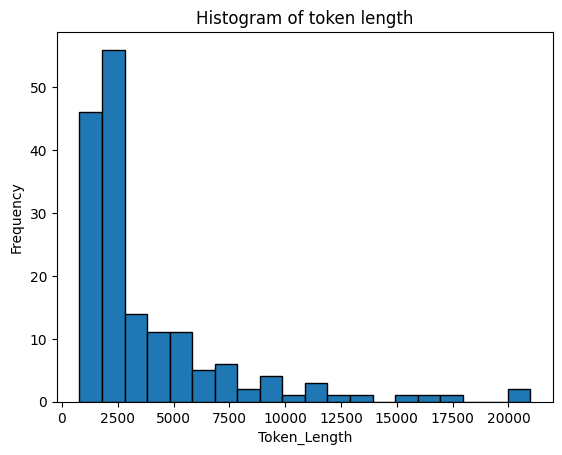

10240

In [7]:
import matplotlib.pyplot as plt

def calculate_max_length(example):
    input_ids = tokenizer(example['text_content'] + example['json_form'])['input_ids']
    return {'length': len(input_ids)}

tokenized_dataset = dataset.map(calculate_max_length)
dataset_length = tokenized_dataset['train']['length']

# Find the maximum tokenized length
max_length = max(dataset_length)

# Plot the diagram for showing distribution of token length
data = tokenized_dataset['train']['length']
plt.hist(data, bins=20, edgecolor='black')
plt.title(f'Histogram of token length')
plt.xlabel('Token_Length')
plt.ylabel('Frequency')
plt.show()

max_length = 10240

max_length

In [8]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

text_column = "text_content"
label_column = "json_form"

dataset, dataset["train"][0]

(DatasetDict({
     train: Dataset({
         features: ['text_content', 'json_form'],
         num_rows: 132
     })
     test: Dataset({
         features: ['text_content', 'json_form'],
         num_rows: 34
     })
 }),
 {'text_content': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nPokÃ©mon TCG Developers PokÃ©mon TCG Developers JOIN THE COMMUNITY OF DEVELOPERS BUILDING WITH THE POKÃ\x89MON TCG API Next The most comprehensive dataset you can find From Base Set through Sword & Shield , the PokÃ©mon TCG API has the card data you need to build the ultimate application, whether that be mobile or web. Get access to prices, hi-res images, and more. Focus on your application and let us worry about the card data. Some features of the PokÃ©mon TCG API include: Prices by TCGplayer Hi-Res Images Detailed Search Queries Developer SDKs With a large community

In [ ]:
# def preprocess_function(data):
# #     model_inputs = tokenizer(data["text_content"],
# #                              max_length=8192,
# #                              truncation=True,
# #                              padding="max_length",
# #                             )
# #     labels = tokenizer(text_target=data["json_form"],
# #                        max_length=4096,
# #                        truncation=True,
# #                        padding="max_length",
# #                       )
   
# #     model_inputs["labels"] = labels["input_ids"]
# #     return model_inputs

# # preprocessed_dataset = dataset.map(preprocess_function,fn_kwargs={"tokenizer": tokenizer})
    
   
#    message = [
#        {"role": "system", "content": ""},
#        {"role": "user", "content": data["text_content"]},
#        {"role": "assistant", "content": data["json_form"]}
#    ]
#    data["text"] = tokenizer.apply_chat_template(message, tokenize=False)
#    return data

# column_names = list(dataset["train"].features)
# preprocessed_dataset = dataset.map(preprocess_function,
#                                    remove_columns=column_names,
#                                    batched=False
#                                   )

In [9]:
def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{x}" for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.pad_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

processed_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/132 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/34 [00:00<?, ? examples/s]

In [10]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 34
    })
})

In [11]:
train_dataset = processed_dataset["train"]
eval_dataset = processed_dataset["test"]
batch_size = 1

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

In [12]:
train_dataset, eval_dataset

(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 132
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 34
 }))

# Prompt tuning - train

In [13]:
from peft import prepare_model_for_kbit_training

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, 
                                  quantization_config=quant_config,
                                 low_cpu_mem_usage=True,
                                 device_map='auto')
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

model.print_trainable_parameters()

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

trainable params: 81,920 || all params: 8,030,343,168 || trainable%: 0.0010


## Method 1: Trainer (HuggingFace)

In [ ]:
from transformers import TrainingArguments

trained_model_id = "Llama-3-8B-Instruct-doc2json"

training_args = TrainingArguments(
    output_dir="output",
    learning_rate=2e-3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_strategy="steps",
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    eval_steps=50,
    warmup_steps=5,
    load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

trainer.train()

## Method 2: PyTorch

In [14]:
num_epochs = 1
lr = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=10,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [15]:
train_loss_per_batch = []
eval_loss_per_batch = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_nan = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)     
        loss = outputs.loss
        if not torch.isnan(loss).any():
            total_loss += loss.detach().float()
        else:
            total_nan += 1
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        print(loss.float())
        train_loss_per_batch.append(loss.detach().float())

    model.eval()
    eval_loss = 0
    eval_preds = []
    eval_nan = 0
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        if not torch.isnan(loss).any():
            eval_loss += loss.detach().float()
            eval_preds.extend(
                tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
            )
        else:
            eval_nan += 1

        eval_loss_per_batch.append(loss.detach().float())

    eval_epoch_loss = eval_loss / (len(eval_dataloader) - eval_nan)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / (len(train_dataloader) - total_nan)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")
    print("train_nan: " + str(total_nan))
    print("eval_nan: " + str(eval_nan))

  0%|          | 0/132 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
  1%|          | 1/132 [00:47<1:44:45, 47.98s/it]

tensor(0.2247, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 2/132 [01:36<1:44:15, 48.12s/it]

tensor(0.2885, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 3/132 [02:24<1:43:50, 48.30s/it]

tensor(0.1191, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 4/132 [03:01<1:33:14, 43.71s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


  4%|▍         | 5/132 [03:50<1:36:30, 45.60s/it]

tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▍         | 6/132 [04:38<1:37:49, 46.58s/it]

tensor(0.3903, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▌         | 7/132 [05:27<1:38:21, 47.21s/it]

tensor(0.3494, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 8/132 [06:16<1:38:45, 47.78s/it]

tensor(0.0997, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 9/132 [07:05<1:38:52, 48.23s/it]

tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 10/132 [07:54<1:38:12, 48.30s/it]

tensor(0.2150, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 11/132 [08:42<1:37:30, 48.35s/it]

tensor(0.2043, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▉         | 12/132 [09:31<1:37:02, 48.52s/it]

tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|▉         | 13/132 [10:19<1:36:13, 48.52s/it]

tensor(0.2843, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 14/132 [11:08<1:35:24, 48.51s/it]

tensor(0.2307, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█▏        | 15/132 [11:56<1:34:31, 48.48s/it]

tensor(0.1737, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 16/132 [12:45<1:34:08, 48.70s/it]

tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 17/132 [13:34<1:33:15, 48.65s/it]

tensor(0.2049, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▎        | 18/132 [14:23<1:32:34, 48.73s/it]

tensor(0.0390, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▍        | 19/132 [15:13<1:32:16, 49.00s/it]

tensor(0.1694, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 20/132 [16:01<1:31:09, 48.84s/it]

tensor(0.1244, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▌        | 21/132 [16:50<1:30:27, 48.90s/it]

tensor(0.0887, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 22/132 [17:39<1:29:38, 48.90s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 23/132 [18:27<1:28:35, 48.76s/it]

tensor(0.1271, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 24/132 [19:16<1:27:38, 48.69s/it]

tensor(0.0813, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 25/132 [20:04<1:26:42, 48.62s/it]

tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|█▉        | 26/132 [20:53<1:25:53, 48.61s/it]

tensor(0.1717, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|██        | 27/132 [21:42<1:25:12, 48.69s/it]

tensor(0.0878, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 28/132 [22:30<1:24:16, 48.62s/it]

tensor(0.1875, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 29/132 [23:19<1:23:40, 48.75s/it]

tensor(0.1462, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 30/132 [24:08<1:22:42, 48.65s/it]

tensor(0.1378, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 31/132 [24:56<1:21:46, 48.58s/it]

tensor(0.1256, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▍       | 32/132 [25:33<1:14:59, 44.99s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▌       | 33/132 [26:21<1:15:56, 46.02s/it]

tensor(0.1031, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▌       | 34/132 [27:10<1:16:29, 46.83s/it]

tensor(0.0608, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 35/132 [27:58<1:16:28, 47.31s/it]

tensor(0.1238, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 36/132 [28:47<1:16:12, 47.63s/it]

tensor(0.2834, device='cuda:0', grad_fn=<NllLossBackward0>)


 28%|██▊       | 37/132 [29:35<1:15:51, 47.91s/it]

tensor(0.0422, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▉       | 38/132 [30:24<1:15:29, 48.18s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|██▉       | 39/132 [31:13<1:14:51, 48.30s/it]

tensor(0.0700, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|███       | 40/132 [32:01<1:14:08, 48.35s/it]

tensor(0.2353, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 41/132 [32:50<1:13:24, 48.40s/it]

tensor(0.1158, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 42/132 [33:38<1:12:37, 48.41s/it]

tensor(0.1825, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 43/132 [34:27<1:11:50, 48.43s/it]

tensor(0.2601, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 44/132 [35:15<1:11:01, 48.43s/it]

tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▍      | 45/132 [36:04<1:10:24, 48.56s/it]

tensor(0.3373, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▍      | 46/132 [36:52<1:09:33, 48.53s/it]

tensor(0.1285, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 47/132 [37:41<1:08:48, 48.57s/it]

tensor(0.1215, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▋      | 48/132 [38:18<1:03:15, 45.19s/it]

tensor(0.1520, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 49/132 [39:07<1:03:54, 46.20s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 50/132 [39:56<1:04:21, 47.09s/it]

tensor(0.1052, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▊      | 51/132 [40:45<1:04:10, 47.54s/it]

tensor(0.0459, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 52/132 [41:33<1:03:42, 47.78s/it]

tensor(0.1797, device='cuda:0', grad_fn=<NllLossBackward0>)


 40%|████      | 53/132 [42:21<1:03:09, 47.96s/it]

tensor(0.2031, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 54/132 [42:58<57:56, 44.57s/it]  

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 55/132 [43:47<58:47, 45.81s/it]

tensor(0.2133, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 56/132 [44:36<59:25, 46.92s/it]

tensor(0.0603, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 57/132 [45:25<59:24, 47.53s/it]

tensor(0.0353, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 58/132 [46:14<58:58, 47.82s/it]

tensor(0.0910, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▍     | 59/132 [47:03<58:39, 48.22s/it]

tensor(0.0699, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▌     | 60/132 [47:51<58:01, 48.36s/it]

tensor(0.1344, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▌     | 61/132 [48:40<57:16, 48.40s/it]

tensor(0.1781, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 62/132 [49:28<56:27, 48.40s/it]

tensor(0.1512, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 63/132 [50:17<55:38, 48.38s/it]

tensor(0.2202, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 64/132 [51:05<54:50, 48.40s/it]

tensor(0.1818, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▉     | 65/132 [51:54<54:01, 48.38s/it]

tensor(0.2051, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 66/132 [52:42<53:23, 48.54s/it]

tensor(0.0502, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 67/132 [53:20<48:55, 45.17s/it]

tensor(4.1081, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 68/132 [54:08<49:19, 46.24s/it]

tensor(0.0591, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 69/132 [54:57<49:19, 46.98s/it]

tensor(0.1501, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 70/132 [55:46<49:01, 47.44s/it]

tensor(0.1275, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▍    | 71/132 [56:34<48:34, 47.78s/it]

tensor(0.0426, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▍    | 72/132 [57:23<48:00, 48.01s/it]

tensor(0.0998, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▌    | 73/132 [58:11<47:19, 48.13s/it]

tensor(0.1320, device='cuda:0', grad_fn=<NllLossBackward0>)


 56%|█████▌    | 74/132 [59:01<46:54, 48.52s/it]

tensor(0.0413, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 75/132 [59:49<46:05, 48.51s/it]

tensor(0.2200, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 76/132 [1:00:38<45:17, 48.52s/it]

tensor(0.1535, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 77/132 [1:01:27<44:39, 48.72s/it]

tensor(0.0910, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▉    | 78/132 [1:02:04<40:39, 45.17s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|█████▉    | 79/132 [1:02:52<40:47, 46.17s/it]

tensor(0.1481, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 80/132 [1:03:41<40:40, 46.92s/it]

tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████▏   | 81/132 [1:04:29<40:15, 47.37s/it]

tensor(1.8519, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 82/132 [1:05:18<39:49, 47.79s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLossBackward0>)


 63%|██████▎   | 83/132 [1:06:07<39:18, 48.14s/it]

tensor(0.2085, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▎   | 84/132 [1:06:44<35:45, 44.71s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▍   | 85/132 [1:07:32<35:54, 45.85s/it]

tensor(0.2222, device='cuda:0', grad_fn=<NllLossBackward0>)


 65%|██████▌   | 86/132 [1:08:21<35:46, 46.67s/it]

tensor(0.1299, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▌   | 87/132 [1:09:09<35:24, 47.22s/it]

tensor(0.1870, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 88/132 [1:09:58<34:57, 47.68s/it]

tensor(0.1517, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 89/132 [1:10:47<34:24, 48.00s/it]

tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 90/132 [1:11:35<33:42, 48.15s/it]

tensor(0.2424, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 91/132 [1:12:24<32:57, 48.24s/it]

tensor(0.1731, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|██████▉   | 92/132 [1:13:12<32:13, 48.33s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|███████   | 93/132 [1:14:01<31:27, 48.39s/it]

tensor(0.1510, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 94/132 [1:14:49<30:40, 48.43s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 95/132 [1:15:38<29:58, 48.60s/it]

tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 96/132 [1:16:27<29:09, 48.59s/it]

tensor(0.1570, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 97/132 [1:17:15<28:19, 48.56s/it]

tensor(0.1100, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 98/132 [1:18:04<27:30, 48.53s/it]

tensor(0.3479, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 99/132 [1:18:52<26:41, 48.54s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▌  | 100/132 [1:19:41<25:52, 48.52s/it]

tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 101/132 [1:20:29<25:04, 48.52s/it]

tensor(0.1076, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 102/132 [1:21:18<24:15, 48.51s/it]

tensor(0.1709, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 103/132 [1:22:07<23:27, 48.55s/it]

tensor(0.2074, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▉  | 104/132 [1:22:55<22:39, 48.54s/it]

tensor(0.2326, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 105/132 [1:23:44<21:52, 48.62s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|████████  | 106/132 [1:24:33<21:04, 48.62s/it]

tensor(0.0674, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 107/132 [1:25:21<20:15, 48.60s/it]

tensor(0.1187, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 108/132 [1:26:10<19:25, 48.57s/it]

tensor(0.1627, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 109/132 [1:26:58<18:37, 48.58s/it]

tensor(0.1016, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 110/132 [1:27:47<17:48, 48.57s/it]

tensor(0.1358, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 111/132 [1:28:35<16:59, 48.55s/it]

tensor(0.0850, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▍ | 112/132 [1:29:24<16:13, 48.66s/it]

tensor(0.0554, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 113/132 [1:30:14<15:29, 48.93s/it]

tensor(0.0890, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▋ | 114/132 [1:31:02<14:38, 48.80s/it]

tensor(0.1345, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 115/132 [1:31:52<13:52, 48.95s/it]

tensor(0.0442, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 116/132 [1:32:40<13:01, 48.86s/it]

tensor(0.0250, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▊ | 117/132 [1:33:29<12:10, 48.72s/it]

tensor(0.1283, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 118/132 [1:34:17<11:21, 48.66s/it]

tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 119/132 [1:35:06<10:31, 48.61s/it]

tensor(0.1828, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 120/132 [1:35:54<09:42, 48.58s/it]

tensor(0.0952, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 121/132 [1:36:43<08:54, 48.60s/it]

tensor(0.0661, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 122/132 [1:37:31<08:05, 48.57s/it]

tensor(0.1501, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 123/132 [1:38:20<07:17, 48.57s/it]

tensor(0.0798, device='cuda:0', grad_fn=<NllLossBackward0>)


 94%|█████████▍| 124/132 [1:39:08<06:28, 48.56s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▍| 125/132 [1:39:46<05:16, 45.18s/it]

tensor(0.2336, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 126/132 [1:40:34<04:37, 46.20s/it]

tensor(0.1858, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▌| 127/132 [1:41:23<03:54, 46.88s/it]

tensor(0.0936, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 128/132 [1:41:59<02:55, 43.81s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 129/132 [1:42:48<02:15, 45.25s/it]

tensor(0.0618, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 130/132 [1:43:36<01:32, 46.24s/it]

tensor(0.1306, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▉| 131/132 [1:44:25<00:46, 46.92s/it]

tensor(0.1750, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 132/132 [1:45:14<00:00, 47.84s/it]


tensor(0.0722, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 34/34 [07:22<00:00, 13.01s/it]

epoch=0: train_ppl=tensor(1.1987, device='cuda:0') train_epoch_loss=tensor(0.1813, device='cuda:0') eval_ppl=tensor(1.1694, device='cuda:0') eval_epoch_loss=tensor(0.1565, device='cuda:0')
train_nan: 6
eval_nan: 0


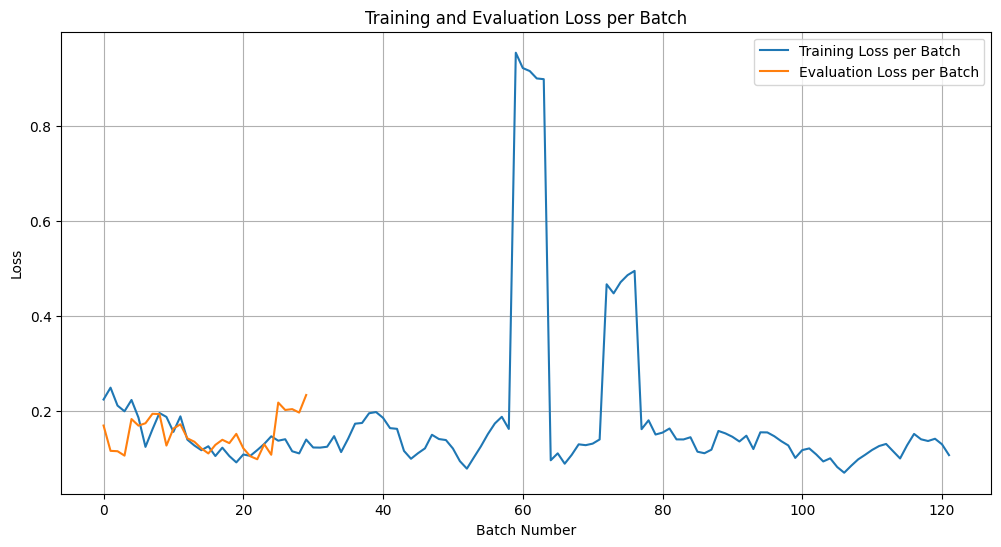

In [16]:
import matplotlib.pyplot as plt
import numpy as np

batch_losses = [x.cpu().numpy() for x in train_loss_per_batch if not torch.isnan(x)]
batch_eval_losses = [x.cpu().numpy() for x in eval_loss_per_batch if not torch.isnan(x)]

def moving_average(data, window_size):
    """ Calculate the moving average using a simple sliding window approach. """
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

# Example usage with a window size of 5
window_size = 5
smoothed_train_loss = moving_average(batch_losses, window_size)
smoothed_eval_loss = moving_average(batch_eval_losses, window_size)

plt.figure(figsize=(12, 6))
plt.plot(smoothed_train_loss, label='Training Loss per Batch')
plt.plot(smoothed_eval_loss, label='Evaluation Loss per Batch', linestyle='-')
plt.title('Training and Evaluation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
with open('eval_preds.txt', 'w') as f:
    for item in eval_preds:
        f.write("%s\n\n" % item)

# Push to the cloud

In [18]:
peft_model_id = "billyfin/APILlama_v2"
model.push_to_hub(peft_model_id, use_auth_token=True, private=True)

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:875: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/328k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/billyfin/APILlama_v2/commit/a1760de2b2545baae91762e364379f6a684ad7f8', commit_message='Upload model', commit_description='', oid='a1760de2b2545baae91762e364379f6a684ad7f8', pr_url=None, pr_revision=None, pr_num=None)

# Load the model

In [ ]:
from peft import PeftModel, PeftConfig
from huggingface_hub import notebook_login
from transformers import AutoModelForCausalLM, AutoModel, AutoTokenizer, default_data_collator, get_linear_schedule_with_warmup, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

notebook_login()

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

peft_model_id = "billyfin/APILlama"

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             quantization_config=quant_config,
                                             low_cpu_mem_usage=True,
                                            )
model = PeftModel.from_pretrained(model, peft_model_id)

# Test & Inference

In [23]:
test_sample = dataset['test']['text_content'][3]

print(test_sample)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

PokÃ©mon TCG Developers PokÃ©mon TCG Developers JOIN THE COMMUNITY OF DEVELOPERS BUILDING WITH THE POKÃMON TCG API Next The most comprehensive dataset you can find From Base Set through Sword & Shield , the PokÃ©mon TCG API has the card data you need to build the ultimate application, whether that be mobile or web. Get access to prices, hi-res images, and more. Focus on your application and let us worry about the card data. Some features of the PokÃ©mon TCG API include: Prices by TCGplayer Hi-Res Images Detailed Search Queries Developer SDKs With a large community contributing to the project through various SDKs, development for you and your team has never been easier. In-depth details of every card All data delivered in JSON format such as types, attacks, abilities, and more. For Developers The PokÃ©mon TCG API

In [24]:
def preprocess_for_inference(examples):
    inputs = f"{examples}"
    
    model_inputs = tokenizer(inputs)
    model_inputs['input_ids'] += [tokenizer.pad_token_id]
    model_inputs["attention_mask"] = [1] * len(model_inputs["input_ids"])
    
    sample_input_ids = model_inputs["input_ids"]
    model_inputs["input_ids"] = [tokenizer.pad_token_id] * (
        max_length - len(sample_input_ids)
    ) + sample_input_ids
    model_inputs["attention_mask"] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
        "attention_mask"
    ]
    model_inputs["input_ids"] = torch.tensor(model_inputs["input_ids"][:max_length])
    model_inputs["attention_mask"] = torch.tensor(model_inputs["attention_mask"][:max_length])
    return model_inputs

test_input = preprocess_for_inference(test_sample)

test_input['input_ids'].shape, test_input['attention_mask'].shape

(torch.Size([10240]), torch.Size([10240]))

In [ ]:
model.train()

inputs = {k: v.unsqueeze(0).to(device) for k, v in test_input.items()}
prompt = inputs['input_ids'].shape[1]
with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs["input_ids"], 
        attention_mask=inputs["attention_mask"],
        max_new_tokens=1024,
        temperature=0.1
    )

print(tokenizer.decode(outputs[0, prompt:], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [26]:
print(dataset['test']['json_form'][3])

{
    "title": "TacoFancy API Documentation",
    "endpoints": [
        {
            "name": "Get Random Taco",
            "description": "Retrieves a random taco recipe including Base Layer, Mixin, Condiment, Seasoning, and Shell.",
            "method": "GET",
            "url": "http://taco-randomizer.herokuapp.com/random/",
            "headers": [],
            "required_parameters": [],
            "optional_parameters": [
                {
                    "name": "full-taco",
                    "type": "boolean",
                    "description": "If set to true, returns a full taco recipe.",
                    "default": false,
                    "example": true
                }
            ]
        },
        {
            "name": "Get Contributors for Recipe",
            "description": "Retrieves information about the contributors for a specific recipe.",
            "method": "GET",
            "url": "http://taco-randomizer.herokuapp.com/contributors/:recipe_t